In [1]:
import lale.helpers
import sklearn.datasets
import sklearn.utils
digits = sklearn.datasets.load_digits()
X_all, y_all = sklearn.utils.shuffle(
    digits.data, digits.target, random_state=42)
holdout_size = 200
X_train, y_train = X_all[holdout_size:], y_all[holdout_size:]
X_test, y_test = X_all[:holdout_size], y_all[:holdout_size]
print('expected\n{}'.format(y_test))

expected
[6 9 3 7 2 1 5 2 5 2 1 9 4 0 4 2 3 7 8 8 4 3 9 7 5 6 3 5 6 3 4 9 1 4 4 6 9
 4 7 6 6 9 1 3 6 1 3 0 6 5 5 1 9 5 6 0 9 0 0 1 0 4 5 2 4 5 7 0 7 5 9 5 5 4
 7 0 4 5 5 9 9 0 2 3 8 0 6 4 4 9 1 2 8 3 5 2 9 0 4 4 4 3 5 3 1 3 5 9 4 2 7
 7 4 4 1 9 2 7 8 7 2 6 9 4 0 7 2 7 5 8 7 5 7 7 0 6 6 4 2 8 0 9 4 6 9 9 6 9
 0 3 5 6 6 0 6 4 3 9 3 9 7 2 9 0 4 5 3 6 5 9 9 8 4 2 1 3 7 7 2 2 3 9 8 0 3
 2 2 5 6 9 9 4 1 5 4 2 3 6 4 8]


In [2]:
from lalegpl.lib.weka import J48
print(f'hyperparam_defaults {J48.hyperparam_defaults()}')
print(f"hyperparam_schema('C') {J48.hyperparam_schema('C')}")

hyperparam_defaults {'U': False, 'O': False, 'C': 0.25, 'M': 2, 'R': False, 'N': 3, 'B': False, 'S': False, 'L': False, 'A': False, 'J': False, 'Q': 1, 'doNotMakeSplitPointActualValue': False, 'output_debug_info': False, 'do_not_check_capabilities': False, 'num_decimal_places': 2, 'batch_size': 100}
hyperparam_schema('C') {'description': 'Set confidence threshold for pruning.', 'type': 'number', 'default': 0.25, 'minimum': 0.01, 'exclusiveMinimum': True, 'maximum': 1, 'exclusiveMaximum': True, 'maximumForOptimizer': 0.5}


In [3]:
trainable_J48 = J48()
trained_J48 = trainable_J48.fit(X_train, y_train)
predicted = trained_J48.predict(X_test)
print('predicted\n{}'.format(predicted))

predicted
[6 9 3 7 2 1 5 3 5 2 2 6 4 0 4 2 3 7 8 8 4 3 9 7 5 6 3 5 6 3 4 9 1 6 4 6 9
 4 7 6 6 9 1 3 6 1 3 0 6 5 5 1 9 5 6 0 3 0 0 8 0 4 5 2 4 5 7 0 7 5 9 5 5 6
 7 0 4 5 5 9 9 0 2 3 8 0 6 4 6 9 1 2 8 3 5 2 9 4 4 4 4 3 7 3 1 8 5 8 4 2 7
 7 4 4 1 9 7 7 8 7 2 6 9 6 2 7 2 7 5 8 7 5 7 7 0 6 6 4 2 8 0 9 4 6 9 9 6 9
 0 3 5 6 6 0 6 4 9 9 3 8 7 2 0 0 4 5 8 6 5 9 9 8 4 2 1 2 7 7 2 2 3 9 8 0 3
 2 2 5 6 9 9 4 1 5 4 2 3 6 4 8]


In [4]:
import sklearn.metrics
print('accuracy {:.1%}\n  for default hyperparams'.format(
    sklearn.metrics.accuracy_score(y_test, predicted)))

accuracy 90.0%
  for default hyperparams


In [5]:
from hyperopt import STATUS_OK, Trials, fmin, tpe, space_eval
from lale.search.op2hp import hyperopt_search_space

def objective(hyperparams):
    trainable = J48(**lale.helpers.dict_without(hyperparams, 'name'))
    trained = trainable.fit(X_train, y_train)
    predictions = trained.predict(X_test)
    accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
    return {'loss': -accuracy, 'status': STATUS_OK}

search_space = hyperopt_search_space(J48)
trials = Trials()
fmin(objective, search_space, algo=tpe.suggest, max_evals=3, trials=trials)
best = J48(**lale.helpers.dict_without(space_eval(search_space, trials.argmin), 'name'))
print('accuracy {:.1%}\n  for hyperparams {}'.format(
    -min(trials.losses()), best.hyperparams()))

100%|██████████████████████| 3/3 [00:02<00:00,  1.28trial/s, best loss: -0.195]
accuracy 19.5%
  for hyperparams {'A': True, 'B': True, 'M': 705}


notebook cell [6] line 4: 2020-03-27_15-49-42 before calling fit on pipeline
notebook cell [6] line 6: 2020-03-27_15-49-43 after calling fit on pipeline


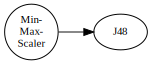

In [6]:
from lale.lib.sklearn import MinMaxScaler
scaler = MinMaxScaler()
trainable_pipe = scaler >> trainable_J48
lale.helpers.println_pos('before calling fit on pipeline')
trained_pipe = trainable_pipe.fit(X_train, y_train)
lale.helpers.println_pos('after calling fit on pipeline')
lale.helpers.to_graphviz(trained_pipe)

In [7]:
predicted = trained_pipe.predict(X_test)
print('accuracy {:.1%}\n  for pipeline with PCA'.format(
    sklearn.metrics.accuracy_score(y_test, predicted)))

accuracy 90.0%
  for pipeline with PCA


In [8]:
lale.helpers.println_pos('successfully reached the end of the notebook')

notebook cell [8] line 1: 2020-03-27_15-49-47 successfully reached the end of the notebook
